# Replication

This notebook replicates exactly the analysis done for this project.


In [1]:
%matplotlib inline

import re
import numpy as np
from Lib import statistics as stat
import datetime as dt
import zipfile
import os

#This file reads data from honeypot dataset, process and write the data into bots.txt and humans.txt

num_decimal = 4


In [2]:
#Reading basic info for each user into container
def read_info(filename, container):
    with open(filename, 'r') as f:
        for line in f:
            tokens = re.split("[\t\n]", line)
            #Parse strings to numbers, take out the dates
            parsed_tokens = [tokens[0]] + [int(r) for r in tokens[3:8]]
            #Remove length of screen name from data, which is found to have negative effect on classification accuracy
            parsed_tokens = parsed_tokens[:3] + parsed_tokens[4:]
            #Add # followings / # followers
            parsed_tokens.append(round((parsed_tokens[1]/parsed_tokens[2] if parsed_tokens[2] else 0), num_decimal))
            container.append(parsed_tokens)


In [3]:
#Reading data of a series of # followings for each user
def read_followings(filename, container):
    with open(filename, 'r') as f:
        i = 0
        for line in f:
            tokens = [int(r) for r in re.split("[\D]", line) if r != ""][1:]
            #Calculate standard deviation of the data
            sd = round(stat.pstdev(tokens), num_decimal)
            #Calcalate standard deviation of differences of the data
            sdd = round(stat.pstdev(list(np.array(tokens[1:]) - np.array(tokens[:-1]))), num_decimal)
            #Calculate lag one autocorrelation of the data
            avg = np.mean(tokens)
            numerator = sum((np.array(tokens[1:]) - avg) * (np.array(tokens[:-1]) - avg))
            denominator = sum((np.array(tokens) - avg) ** 2)
            lac = round(numerator/denominator, num_decimal) if denominator != 0 else 0
            container[i] += [sd, sdd, lac]
            i += 1


In [4]:
#Reading tweets posted by each user
def read_tweets(filename, container):
    curr_userID = ""
    curr_tweet_count = 0
    #Features contained in tweets (current user)
    urls, _at_s, hashtags, weekday_post = [], [], [], []
    #Index for container
    i = 0
    with open(filename, encoding = 'utf-8', mode = 'r') as f:
        while True:
            line = f.readline()
            tokens = [r for r in re.split("[\t\n]", line) if r != ""]
            if not line or tokens[0] != curr_userID and curr_userID:
                #New user found / eof reached
                num_tweets_weekday = [weekday_post.count(i) for i in range(7)]
                ratio_tweets_weekday = [round(x, num_decimal) for x in list(np.array(num_tweets_weekday) / len(weekday_post))]
                curr_user = num_tweets_weekday + ratio_tweets_weekday
                for feature in (urls, _at_s, hashtags):
                    curr_user.append(round(len(feature) / curr_tweet_count, num_decimal))
                    curr_user.append(round(len(set(feature)) / curr_tweet_count, num_decimal))
                while curr_userID != container[i][0]:
                    i += 1
                container[i] += curr_user
                if not line:
                    break
                #Reset current user info containers
                curr_tweet_count = 0
                urls, _at_s, hashtags, weekday_post = [], [], [], []
            #Post date of the tweet
            curr_userID = tokens[0]
            curr_tweet_count += 1
            urls += re.findall('http[\S]+', tokens[2])
            _at_s += re.findall('@[\S]+', tokens[2])
            hashtags += re.findall('#[\S]+', tokens[2])
            post_date = re.split("[-\s]", tokens[3])
            post_date = dt.date(int(post_date[0]), int(post_date[1]), int(post_date[2]))
            weekday_post.append(post_date.weekday())


In [5]:
#Deleting ambiguous users who are in both polluters and legitimate users (44 found)
#The user ids are found in ascending order
def del_amb(bots, humans):
    i, j, count = (0, 0, 0)
    while i < len(bots) and j < len(humans):
        if bots[i][0] == humans[j][0]:
            bots.pop(i)
            humans.pop(j)
            count += 1
        elif int(bots[i][0]) < int(humans[j][0]):
            i += 1
        else:
            j += 1
    return count

#Add 0's for missing values (some users have no tweets recorded)
def add0(container):
    length = 29
    for i in range(len(container)):
        container[i] += [0]*(length - len(container[i]))


In [6]:
#Write data into text files
def write_user(filename, container):
    with open(filename, 'w') as f:
        for inst in container:
            f.write("\t".join([str(x) for x in inst]))
            f.write("\n")


In [7]:
#Download the dataset
if not os.path.exists('social_honeypot_icwsm_2011'):
    if not os.path.exists('social_honeypot_icwsm_2011.zip'):
        print("downloading data")
        urlretrieve('http://infolab.tamu.edu/static/users/kyumin/social_honeypot_icwsm_2011.zip', 'social_honeypot_icwsm_2011.zip')
    zip = zipfile.ZipFile('social_honeypot_icwsm_2011.zip')
    zip.extractall(path = 'social_honeypot_icwsm_2011')
    zip.close()
    print("data ready")


In [8]:
#Read, process, and write data into text files
#It takes a few minutes to run, and should run for only once
bots, humans = [], []
read_info('social_honeypot_icwsm_2011\content_polluters.txt', bots)
print("data read from social_honeypot_icwsm_2011\content_polluters.txt")
read_info('social_honeypot_icwsm_2011\legitimate_users.txt', humans)
print("data read from social_honeypot_icwsm_2011\legitimate_users.txt")

read_followings('social_honeypot_icwsm_2011\content_polluters_followings.txt', bots)
print("data read from social_honeypot_icwsm_2011\content_polluters_followings.txt")
read_followings('social_honeypot_icwsm_2011\legitimate_users_followings.txt', humans)
print("data read from social_honeypot_icwsm_2011\legitimate_users_followings.txt")

read_tweets('social_honeypot_icwsm_2011\content_polluters_tweets.txt', bots)
print("data read from social_honeypot_icwsm_2011\content_polluters_tweets.txt")
read_tweets('social_honeypot_icwsm_2011\legitimate_users_tweets.txt', humans)
print("data read from social_honeypot_icwsm_2011\legitimate_users_tweets.txt")

count = del_amb(bots, humans)
print("%d mislabeled users deleted!" % count)
add0(bots)
add0(humans)
print("added 0's for missing values")
    
write_user('bots.txt', bots)
print("data written to bots.txt")
write_user('humans.txt', humans)
print("data written to humans.txt")


data read from social_honeypot_icwsm_2011\content_polluters.txt
data read from social_honeypot_icwsm_2011\legitimate_users.txt


KeyboardInterrupt: 


Below are code from analyze.py


In [9]:
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt

#This file reads data from polluters.txt and legitimate_users.txt and do analysis on the data


In [10]:
#Read data from polluters.txt and legitimate_users.txt
polluters = []
reader_1 = open("bots.txt", 'r')
for line in reader_1:
    tokens = [float(r) for r in re.split("[\t\n]", line) if r != ""]
    polluters.append(tokens)
reader_1.close()
print("data read from polluters.txt")
    
legitimate_users = []
reader_2 = open("humans.txt", 'r')
for line in reader_2:
    tokens = [float(r) for r in re.split("[\t\n]", line) if r != ""]
    legitimate_users.append(tokens)
reader_2.close()
print("data read from legitimate_users.txt")


#Combine 2 datasets for classification, dataset_Y is the target list
dataset_X = [r[1:] for r in polluters + legitimate_users]
dataset_Y = [0] * len(polluters) + [1] * len(legitimate_users)


data read from polluters.txt
data read from legitimate_users.txt


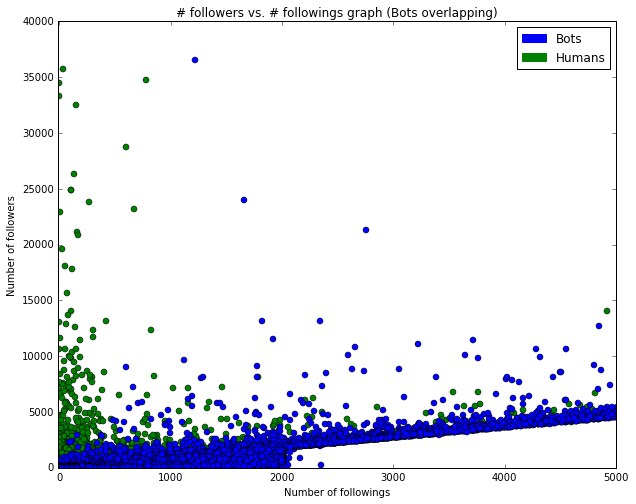

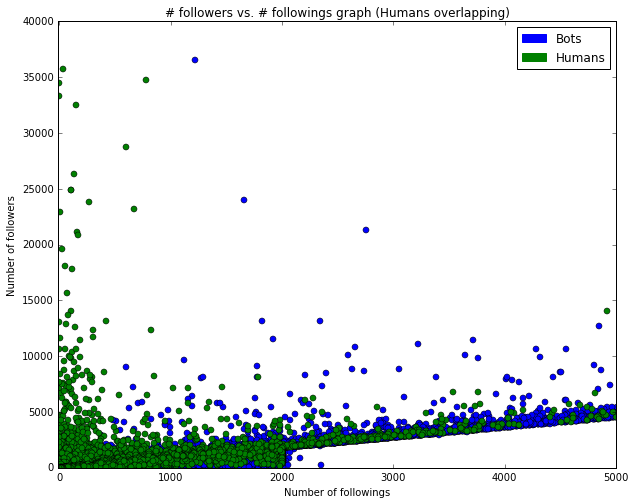

In [11]:
#Plot graph of #followers / #followings to see the data distribution patterns
humans_patch = mpatches.Patch(color='green', label='Humans')
bots_patch = mpatches.Patch(color='blue', label='Bots')
plt.figure(figsize=(10, 8))
plt.plot([x[0] for x in dataset_X][len(polluters):], [x[1] for x in dataset_X][len(polluters):], "go")
plt.plot([x[0] for x in dataset_X][:len(polluters)], [x[1] for x in dataset_X][:len(polluters)], "bo")
plt.legend(handles=[bots_patch, humans_patch])
plt.axis([-10, 5000, -10, 40000])
plt.ylabel("Number of followers")
plt.xlabel("Number of followings")
plt.title("# followers vs. # followings graph (Bots overlapping)")
plt.show()

plt.figure(figsize=(10, 8))
plt.plot([x[0] for x in dataset_X][:len(polluters)], [x[1] for x in dataset_X][:len(polluters)], "bo")
plt.plot([x[0] for x in dataset_X][len(polluters):], [x[1] for x in dataset_X][len(polluters):], "go")
plt.legend(handles=[bots_patch, humans_patch])
plt.axis([-10, 5000, -10, 40000])
plt.ylabel("Number of followers")
plt.xlabel("Number of followings")
plt.title("# followers vs. # followings graph (Humans overlapping)")
plt.show()



Below are code from classify.py


In [12]:
from sklearn.linear_model import LogisticRegressionCV, LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn import cross_validation
from sklearn.metrics import f1_score, confusion_matrix
from sklearn.cross_validation import KFold
from sklearn.cross_validation import train_test_split

#This file reads data from polluters.txt and legitimate_users.txt and classify the records


In [13]:
#Separate dataset_X into bins by # followings and # followers and try classification
#Drop some outliers based on the # followers vs. #followings graph
data_x = []
data_y = []
outliers_x = []
outliers_y = []
i = 0
while i < len(dataset_X):
    if dataset_X[i][0] < 500:
        if dataset_X[i][1] > 1500:
            data_x.append(dataset_X[i] + [1, 0, 0])
            data_y.append(dataset_Y[i])
        else:
            data_x.append(dataset_X[i] + [0, 1, 0])
            data_y.append(dataset_Y[i])
    elif dataset_X[i][1] < dataset_X[i][0]*0.9+10000:
        #The #followers/#followings ratio is below the generalized line
        if dataset_X[i][0] < 2005:
            data_x.append(dataset_X[i] + [0, 1, 0])
            data_y.append(dataset_Y[i])
        else:
            data_x.append(dataset_X[i] + [0, 0, 1])
            data_y.append(dataset_Y[i])
    else:
        outliers_x.append(dataset_X[i])
        outliers_y.append(dataset_Y[i])
    i += 1
dataset_X = data_x
dataset_Y = data_y
print("%d outliers are dropped" % len(outliers_x))


57 outliers are dropped


In [14]:
#Scale each feature of the data with its maximum value
#This is found to give a better result than no scale or scale with both maximum and standard deviation
max_values = np.matrix(data_x).mean(0).tolist()[0][:-1] + [1]
data_x = [[x/y for x, y in list(zip(z, max_values))] for z in data_x]
print("data scaled")
print("%d instances, where %g are bots" % (len(data_x), data_y.count(0)/len(data_y)))


data scaled
41354 instances, where 0.535136 are bots


In [15]:
#Need KFold iterator since method "cross_val_score" doesn't provide shuffling function
kFold = KFold(n = len(dataset_X), n_folds = 10, shuffle = True)

#Build the classifier and do classification based on: all numeric features & each numeric feature
lr = LogisticRegression()
rf = RandomForestClassifier(criterion = 'entropy', n_estimators = 50)


In [16]:
#Do classification with Random Forest classifier
#This takes a minute to run

#First use cross_val_score to get a total accuracy
score = np.mean(cross_validation.cross_val_score(rf, dataset_X, dataset_Y, cv = kFold))
print("\naccuracy:\ntotal:\t%g%%" % round(score*100, 2))

#Then do cross validation manually to get the f1 score and confusion matrix
#Also count misclassified bots and humans respectively, and calculate the accuracies respectively
e_h, e_b = 0, 0
predictions, y_tests = [], []

for train_index, test_index in kFold:
    dataset_X, dataset_Y = np.array(dataset_X), np.array(dataset_Y)
    X_train, X_test = list(dataset_X[train_index]), list(dataset_X[test_index])
    y_train, y_test = list(dataset_Y[train_index]), list(dataset_Y[test_index])
    rf.fit(X_train, y_train)
    prediction = list(rf.predict(X_test))
    predictions += prediction
    y_tests += y_test
    i = 0
    while i < len(y_test):
        if prediction[i] != y_test[i]:
            if y_test[i] == 0:
                e_b += 1
            else:
                e_h += 1
        i += 1
f1_bots = f1_score(y_tests, predictions, pos_label = 0)
f1_humans = f1_score(y_tests, predictions, pos_label = 1)
conf_matrix = np.matrix(list(confusion_matrix(y_tests, predictions)))

print("humans:\t%g%%" % round((1 - e_h/y_tests.count(1))*100, 2))
print("bots:\t%g%%" % round((1 - e_b/y_tests.count(0))*100, 2))
print("\nf1 scores:\nhumans:\t%g%%\nbots:\t%g%%" % (round(f1_humans*100, 2), round(f1_bots*100, 2)))
print("\nconfusion matrix:\n", conf_matrix, "\n")

#FYI, the labels for confusion matrix are:
#         classified as
#         bots     humans
# bots
# humans



accuracy:
total:	95.1%
humans:	93.79%
bots:	96.3%

f1 scores:
humans:	94.72%
bots:	95.49%

confusion matrix:
 [[21312   818]
 [ 1194 18030]] 

